<br>
<u>Notebook Twelve</u> | 
<a href=https://leone.gdn/DLL target=_blank>Report</a> | 
<a href=https://github.com/andrealeone/DLL>Repository</a>
<br><br>
<b>Task 2: Re-Identification</b><br><br>
Andrea Leone, Alessandro E. Piotti<br>
Deep Learning Lab — University of Trento<br>
December 2021
<hr><br><br>

In [1]:
import project 
import networks

import os
import pickle
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn          as nn
import torchvision

import sklearn
import sklearn.neighbors
import sklearn.decomposition
import sklearn.manifold
import lpips

from tqdm.notebook   import tqdm

project.notebook()

In [2]:
_, annotations = project.load_resources() 

<hr><br><br>

## Re-identification

<br><br>Load the images as reference

In [3]:
images     = pickle.load( open('./data/images.pkl',        'rb') ) 

<br><br>Load the pre-computed image attributes

In [4]:
attributes = pickle.load( open('./data/attributes.v2.pkl', 'rb') ) 

In [5]:
test_ids_iloc = list( attributes['test'].keys() ) 
arrays = [ (array - 1) for array in attributes['test'].values() ] 

<br><br>Load the siamese network

In [6]:
h = '30' 
w = './models/siamese_cnn.v4.x{}.net'.format(h) 

model = networks.SiameseCNN()
model.load_state_dict( torch.load(w) )
model

SiameseCNN(
  (cnv1): Conv2d(3, 30, kernel_size=(5, 5), stride=(1, 1))
  (cnv2): Conv2d(30, 20, kernel_size=(4, 4), stride=(1, 1))
  (cnv3): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=480, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=2, bias=True)
)

<hr>

<br><br>Sample query

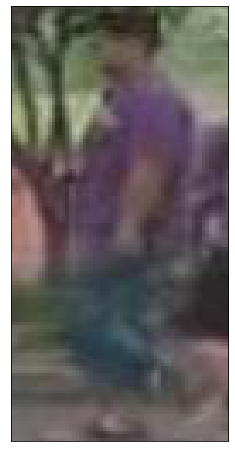

In [7]:
q_n   =  15 
q_id  = '000000' 
q_img =  images['queries'][q_id][0].int() 

project.plot_image(q_img)

<br><br>Attribute similarity

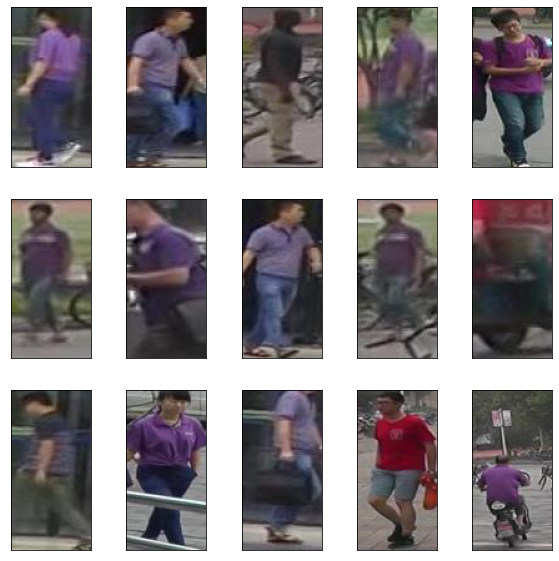

In [8]:
q     = attributes['queries'][q_id] - 1 
q_res = sorted([ 
    [ test_ids_iloc[_i], _dist[0] ] for _i, _dist in enumerate(
        sklearn.metrics.pairwise.cosine_similarity(arrays, [q])
    )
], key=lambda x : x[1], reverse=True)

project.plot_images([ 
    images['test'][ _id ][0]
    for _id,_ in q_res[:q_n]
]) 

<br><br>SiameseNet

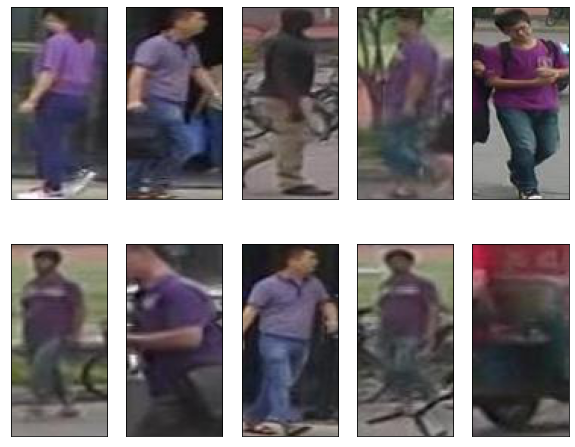

In [9]:
q_res_lim  = 30 
q_res_trs  = 3

q_res2     = collections.Counter()
q_embed    = model( images['queries'][q_id] )[0].detach().numpy() 
q_embeds   = [ 
    model( images['test'][_id] )[0].detach().numpy()
    for _id,_ in q_res[:q_res_lim]
]

for _ in range(q_res_trs):
    q_res2.update( dict([ 
        [ _id, int((q_res_lim-_i)/3) ] for _i,(_id,_) in enumerate(
            [ q_res[_i][0], _dist ] for _i,_dist in sorted([ 
                [ _i,float(_dist) ] for _i,_dist in enumerate(
                    sklearn.metrics.pairwise.cosine_similarity( 
                        q_embeds, [ q_embed ]
                    )
                )
            ], key=lambda x:x[1], reverse=True)
        )
    ]))

q_res2 = q_res2.most_common()

project.plot_images([ 
    images['test'][ _id ][0]
    for _id,_ in q_res2[:10]
], fs=(10,8)) 

<br><br>LPIPS similarity

  0%|          | 0/30 [00:00<?, ?it/s]

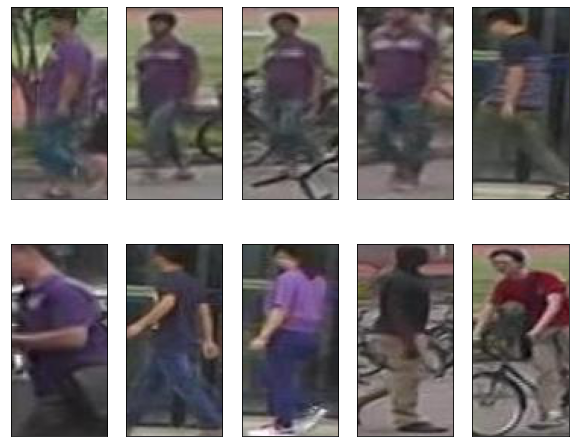

In [10]:
q_res3     = dict() 
lpips_mods = dict()
lpips_nets = [ 'alex', 'vgg' ]

for net in lpips_nets:
    
    q_res3[ net ]     = list()
    lpips_mods[ net ] = lpips.LPIPS(
        net=net, eval_mode=True,
        pretrained=True, verbose=False
    )

for _id,_ in tqdm( q_res2[:q_res_lim] ):
    for net, mod in lpips_mods.items():
    
        img  = images['test'][_id][0].int()
        loss = float( mod.forward( q_img, img ) )

        q_res3[ net ].append([ _id, loss ])

q_res3C = collections.Counter()
for net in lpips_nets: 
    
    q_res3C.update(
        collections.Counter(dict([ 
            [ _id,_i ] for _i,(_id,_) in enumerate(sorted(
                q_res3[net], key=lambda x:x[1], reverse=True
            ))
        ]))
    )

q_res3 = q_res3C.most_common()

project.plot_images([ 
    images['test'][ _id ][0]
    for _id,_ in q_res3[:10]
], fs=(10,8)) 

<hr>

<br><br>
Load the ReID logic above in a single method

In [11]:
reid = lambda q_id : project.reid_model(q_id, 
    images, attributes, arrays, model
)

Set a threshold for the ranking and filter the results

In [12]:
filter_threshold = 45 
filter_results   = lambda results : [
    (k) for k,v in results if v > filter_threshold
]

Compute results for all queries and export them

In [13]:
reid_results = dict() 

for q_key in tqdm( list(images['queries'].keys()) ):
    reid_results[q_key] = filter_results( reid( q_key ) ) 

with open('./data/reid_test.txt', 'w') as file: 

    file.write('\n'.join([
        '{}: {}'.format(key, ', '.join(results))
        for key, results in reid_results.items()
    ]))

  0%|          | 0/2248 [00:00<?, ?it/s]

<br><br>